In [2]:
import pandas as pd

/tmp/ipykernel_11555/886917232.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  M_RGB  = M_RGB.astype(np.int)


[[74 54 40 ... 80 72 57]
 [99 79 70 ... 66 43 48]
 [88 74 72 ... 61 56 65]
 ...
 [16 82 60 ... 58 60 59]
 [21 88 71 ... 57 59 57]
 [32 74 64 ... 68 59 55]]


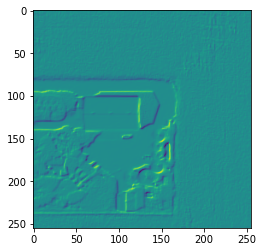

"image=clipped\n\ndistance = ndi.distance_transform_edt(image)\ncoords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)\nmask = np.zeros(distance.shape, dtype=bool)\nmask[tuple(coords.T)] = True\nmarkers, _ = ndi.label(mask)\nlabels = watershed(-distance, markers, mask=image)\n\nfig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)\nax = axes.ravel()\n\nax[0].imshow(image, cmap=plt.cm.gray)\nax[0].set_title('Overlapping objects')\nax[1].imshow(-distance, cmap=plt.cm.gray)\nax[1].set_title('Distances')\nax[2].imshow(labels, cmap=plt.cm.nipy_spectral)\nax[2].set_title('Separated objects')\n\nfor a in ax:\n    a.set_axis_off()\n\nfig.tight_layout()\nplt.savefig('teste2.png')\nplt.show()\n\n# ---\n\n\nimg = cv.imread('opencv-logo-white.png',0)\nimg = cv.medianBlur(img,5)\ncimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)\ncircles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,\n                            param1=50,param2=30,minRadius=0,maxRadius=0)\ncircles 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# ---
# import cv2 as cv
# ---
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

def png_2_RGB(file):
    """
    Convertit l'image 'file' au format png en 3 matrices 
    -------------
    paramètres :
    file : nom du fichier png à convertir 
    
    retourne :
    M_R, M_G, M_B : les matrices contenant l'intensité (sur 255) repectivement du rouge, vert et bleu en chaque point 
    """
    
    #plt.imread retourne l'image au bon format avec une quatrième valeur pour la transparence qu'on ne conserve pas 
    M_RGB  = plt.imread(file)[:,:,:3]
    #M_RGB contient des valeurs entre 0 et 1 qui correspondent en fait à des entiers entre 0 et 255
    M_RGB *= 255
    #passage en entier (le stockage des entier allant de 1 à 255 est plus faible que celui des flottants)
    M_RGB  = M_RGB.astype(np.int)
    
    return M_RGB[:,:,0], M_RGB[:,:,1], M_RGB[:,:,2]


# on utilisera dans un premier temps l'image suivante
M_R, M_G, M_B = png_2_RGB('ai_ready/images/silos_256-0-0--6-16--635-28790.png')

def image_diff(image):
    img_diff=image[:-1,:-1]-image[1:,1:]
    return img_diff

clipped = image_diff((M_R+M_G+M_B))+64
print(clipped)

plt.figure()
plt.imshow(clipped)
plt.savefig('teste.png')
plt.show()

# -----
"""image=clipped

distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.savefig('teste2.png')
plt.show()

# ---


img = cv.imread('opencv-logo-white.png',0)
img = cv.medianBlur(img,5)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
cv.imshow('detected circles',cimg)
cv.waitKey(0)
cv.destroyAllWindows()"""

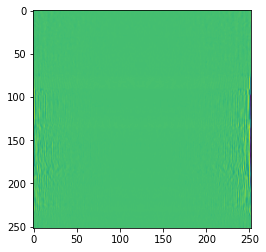

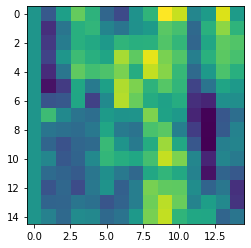

In [5]:
plt.imshow(np.fft.fft(M_R).real[4:,4:])
plt.show()
plt.imshow(np.fft.fft(M_R).imag[:15,:15])
plt.show()

In [6]:
'''
Created on May 30, 2012
@author: vinnie
'''

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
from scipy.signal import fftconvolve
from scipy.ndimage import filters

_MIN_RADIUS = 15
_MAX_RADIUS = 75
_RADIUS_STEP = 5
_ANNULUS_WIDTH = 5
_EDGE_THRESHOLD = 0.005
_NEG_INTERIOR_WEIGHT = 1.1

def _detectEdges(image, threshold):
    """
    Sobel edge detection on the image
    """
    # sobel filter in x and y direction
    image = filters.sobel(image, 0)**2 + filters.sobel(image, 1)**2 
    image -= image.min()
    
    # make binary image
    image = image > image.max()*threshold
    image.dtype = np.int8
        
    return image

def _makeAnnulusKernel(outer_radius, annulus_width):
    """
    Create an annulus with the given inner and outer radii
    
    Ex. inner_radius = 4, outer_radius = 6 will give you:
    
    
    """
    grids = np.mgrid[-outer_radius:outer_radius+1, -outer_radius:outer_radius+1]
    
    # [j][i] = r^2 
    kernel_template = grids[0]**2 + grids[1]**2
    
    # get boolean value for inclusion in the circle
    outer_circle = kernel_template <= outer_radius**2
    inner_circle = kernel_template < (outer_radius - annulus_width)**2
    
    # back to integers
    outer_circle.dtype = inner_circle.dtype = np.int8
    inner_circle = inner_circle*_NEG_INTERIOR_WEIGHT
    annulus = outer_circle - inner_circle
    return annulus

def _detectCircles(image, radii, annulus_width):
    """
    Perfrom a FFT Convolution over all the radii with the given annulus width.
    Smaller annulus width = more precise
    """
    acc = np.zeros((radii.size, image.shape[0], image.shape[1]))

    for i, r in enumerate(radii):
        C = _makeAnnulusKernel(r, annulus_width)
        acc[i,:,:] = fftconvolve(image, C, 'same')

    return acc

def _iterativeDetectCircles(edges, image):
    """
    TODO: finish this
    
    The idea:
    Start with an annulus with a large radius.
    Split this into 2 annuli of equal area. The annulus width will be different
    Find the annulus with a higher signal in the image
    Repeat the process for the higher signal, 
    until a minumum annulus width is reached (preferrably 1)
    
    Initialize:
    large radius = min(image.shape)/2 ... actually maybe a little less
    min radius is some small number, not too small to avoid high match to noise
    
    TODO: the signals for each annulus have to be comparable
             solution? -> normalize to the area of the annulus
    """
    
    
    return

def _displayResults(image, edges, center, radius, output=None):
    """
    Display the accumulator for the radius with the highest votes.
    Draw the radius on the image and display the result.
    """
    
    # display accumulator image
    plt.gray()
    fig = plt.figure(1)
    fig.clf()
    subplots = []
    subplots.append(fig.add_subplot(1, 2, 1))
    plt.imshow(edges)
    plt.title('Edge image')
    
    # display original image
    subplots.append(fig.add_subplot(1, 2, 2))
    plt.imshow(image)
    plt.title('Center: %s, Radius: %d' % (str(center), radius))
    # draw the detected circle
    blob_circ = plt_patches.Circle(center,radius, fill=False, ec='red')
    plt.gca().add_patch(blob_circ)
    
    #   Fix axis distortion:
    plt.axis('image')

    if output:
        plt.savefig(output)
        
    plt.draw()
    plt.show()
    
    return

def _topNCircles(acc, radii, n):
    
    maxima = []
    max_positions = []
    max_signal = 0
    for i, r in enumerate(radii):
        max_positions.append(np.unravel_index(acc[i].argmax(), acc[i].shape))
        maxima.append(acc[i].max())
        # use the radius to normalize
        signal = maxima[i]/np.sqrt(float(r))
        
        if signal > max_signal:
            max_signal = signal
            (circle_y, circle_x) = max_positions[i]
            radius = r
        print ("Maximum signal for radius %d: %d %s, normal signal: %f" % (r, maxima[i], max_positions[i], signal))
        

    # Identify maximum. Note: the values come back as index, row, column
#    max_index, circle_y, circle_x = np.unravel_index(acc.argmax(), acc.shape)
    
    return (circle_x, circle_y), radius #radii[max_index]

def DetectCircleFromFile(filename, show_result=False):
    
    image = plt.imread(filename)
    center, radius = DetectCircle(image, True, show_result)
    return center, radius

def DetectCircle(image, preprocess=False, show_result=False):
    
    if preprocess:
        if image.ndim > 2:
            image = np.mean(image, axis=2)
        print ("Image size: ", image.shape)
        
        # noise reduction
        image = filters.gaussian_filter(image, 2)
        
        # edges and density
        edges = _detectEdges(image, _EDGE_THRESHOLD)
        edge_list = np.array(edges.nonzero())
        density = float(edge_list[0].size)/edges.size
        print ("Signal density:", density)
        if density > 0.25:
            print ("High density, consider more preprocessing")
            
    # create kernels and detect circle
    radii = np.arange(_MIN_RADIUS, _MAX_RADIUS, _RADIUS_STEP)
    acc = _detectCircles(edges, radii, _ANNULUS_WIDTH)
    center, radius = _topNCircles(acc, radii, 1)
    print ("Circle detected at ", center, radius)
    
    if show_result:
        _displayResults(image, edges, center, radius)
                        
    return center, radius

def _run(filename):
    return DetectCircleFromFile(filename)

def _test():
#    ## TODO: test cases, especially for iterative approach
#    radii = np.arange(_MIN_RADIUS, _MAX_RADIUS, _RADIUS_STEP)
#    image, edges = _initialize('mri.png')
#    acc = _detectCircles(edges, radii, _ANNULUS_WIDTH)
#    center, radius = _topNCircles(acc, radii, 1)
#    print "Circle detected at ", center, radius
#    _displayResults(image, edges, acc, radii, "mri-result.png")
#    return
    DetectCircleFromFile('mri2.png', True)
#    DetectCircleFromVideo("/home/vinnie/workspace/Intelligent-Artifacts/AMID/data/MRI_SAX_AVI/321/(MAIN)04052012-173005.avi")
    
if __name__ == "__main__":
    if (len(sys.argv) > 1):
        _run(sys.argv[1])
    else:
        _test();

FileNotFoundError: [Errno 2] No such file or directory: '--ip=127.0.0.1'

In [ ]:
M_R, M_G, M_B = png_2_RGB('ai_ready/images/silos_256-0-0--6-16--635-28790.png')

/tmp/ipykernel_6348/886917232.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  M_RGB  = M_RGB.astype(np.int)


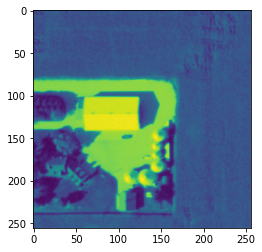

In [7]:
plt.imshow(M_G+M_R+M_B)

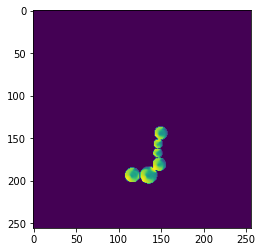

In [8]:
plt.imshow(np.multiply(plt.imread('ai_ready/masks/silos_256-0-0--6-16--635-28790.png'),M_R));plt.show()

In [9]:
np.multiply(plt.imread('ai_ready/masks/silos_256-0-0--6-16--635-28790.png'),M_R).sum()

202414.0

In [10]:
plt.imread('ai_ready/masks/silos_256-0-0--6-16--635-28790.png').sum()

1110.0

In [11]:
202414/1110

182.35495495495496

In [12]:
def average_silo_color(file):
    M_R, M_G, M_B = png_2_RGB('ai_ready/images/'+file)
    mask = plt.imread('ai_ready/masks/'+file)
    mask_size=mask.sum()
    r_val=np.multiply(mask,M_R).sum()/mask_size
    g_val=np.multiply(mask,M_G).sum()/mask_size
    b_val=np.multiply(mask,M_B).sum()/mask_size
    return r_val,g_val,b_val

In [13]:
average_silo_color('silos_256-0-0--6-16--635-28790.png')

/tmp/ipykernel_11555/886917232.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  M_RGB  = M_RGB.astype(np.int)


(182.35495495495496, 187.87747747747747, 199.4945945945946)

In [14]:
average_silo_color('silos_256-0-0--6-16--1346-28601.png')

/tmp/ipykernel_11555/886917232.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  M_RGB  = M_RGB.astype(np.int)


(182.54676258992805, 189.26708633093526, 198.02877697841726)

In [15]:
data=pd.read_csv('ai_ready/x-ai_data.csv')

In [16]:
with_silos=data[data['class']==1]
with_silos_train=with_silos[with_silos['split']=='train']

In [17]:
with_silos_train.reset_index()

,index,filename,class,split
0,999,silos_256-0-0--6-15-174-31048.png,1,train
1,1000,silos_256-0-0--6-15-651-30254.png,1,train
2,1001,silos_256-0-0--6-15--1137-31027.png,1,train
3,1002,silos_256-0-0--6-16--936-30650.png,1,train
4,1003,silos_256-0-0--6-16--1204-28815.png,1,train
...,...,...,...,...
702,1992,silos_256-0-0--6-15--563-30296.png,1,train
703,1994,silos_256-0-0--6-16--482-29384.png,1,train
704,1996,silos_256-0-0--6-16--1142-28595.png,1,train
705,1997,silos_256-0-0--6-15--328-29482.png,1,train


In [18]:
avg_silo_colors=np.zeros((len(with_silos_train),3))

In [19]:
avg_silo_colors

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [20]:
for i in range(len(with_silos_train)):
    avg_silo_colors[i,:]=average_silo_color(with_silos_train.iloc[i]['filename'])

/tmp/ipykernel_11555/886917232.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  M_RGB  = M_RGB.astype(np.int)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0001768 , 0.00070721,
       0.00053041, 0.00123762, 0.00194484, 0.00300566, 0.00406648,
       0.00742574, 0.00583451, 0.00689533, 0.01113861, 0.00990099,
       0.01166902, 0.0155587 , 0.01272984, 0.01219943, 0.0102546 ,
       0.00618812, 0.00212164, 0.00106082, 0.00035361, 0.        ,
       0.        , 0.        ])

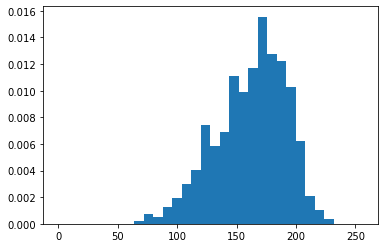

In [135]:
plt.hist(avg_silo_colors[:,0],density=True,bins=np.linspace(0,256,33))[0]

In [21]:
def f_r(x):
    densities=np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.0001768 , 0.00070721,
        0.00053041, 0.00123762, 0.00194484, 0.00300566, 0.00406648,
        0.00742574, 0.00583451, 0.00689533, 0.01113861, 0.00990099,
        0.01166902, 0.0155587 , 0.01272984, 0.01219943, 0.0102546 ,
        0.00618812, 0.00212164, 0.00106082, 0.00035361, 0.        ,
        0.        , 0.        ])
    return densities[min(int(np.floor(32*x)),31)]
 
def f_g(x):
    densities=np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0001768 , 0.0001768 ,
       0.00035361, 0.00088402, 0.00123762, 0.00247525, 0.00477369,
       0.00353607, 0.00565771, 0.00724894, 0.00972419, 0.01184583,
       0.0104314 , 0.01485149, 0.01308345, 0.01520509, 0.01184583,
       0.00742574, 0.00265205, 0.00106082, 0.00035361, 0.        ,
       0.        , 0.        ])
    return densities[min(int(np.floor(32*x)),31)]
 
def f_b(x):
    densities=np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0001768 , 0.00035361,
       0.        , 0.00053041, 0.00141443, 0.00106082, 0.00282885,
       0.00388967, 0.00371287, 0.00830976, 0.00724894, 0.01113861,
       0.0153819 , 0.01308345, 0.01732673, 0.01272984, 0.01131542,
       0.00919378, 0.00318246, 0.00176803, 0.        , 0.00035361,
       0.        , 0.        ])
    return densities[min(int(np.floor(32*x)),31)]

In [29]:
file=with_silos_train.iloc[64]['filename']
img_r=plt.imread('ai_ready/images/'+file)[:,:,0]
img_g=plt.imread('ai_ready/images/'+file)[:,:,1]
img_b=plt.imread('ai_ready/images/'+file)[:,:,2]

In [30]:
def filter(img,channel='r'):
    img_filter=np.zeros(img.shape)
    def f(x,ch):
        if ch=='r':
            return f_r(x)
        if ch=='g':
            return f_g(x)
        if ch=='b':
            return f_b(x)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_filter[i,j]=f(img[i,j],channel)*img[i,j]
    return img_filter

In [31]:
filter(img_r,channel='r').shape

(256, 256)

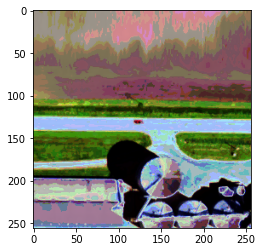

In [37]:
plt.imshow(np.transpose(np.array([80*filter(img_r,channel='r'),80*filter(img_g,channel='g'),80*filter(img_b,channel='b')]),(1,2,0)));

In [33]:
def filter2(img):
    img_filter_r=np.zeros((256,256))
    img_filter_g=np.zeros((256,256))
    img_filter_b=np.zeros((256,256))
    def f(x,ch):
        if ch=='r':
            return f_r(x)
        if ch=='g':
            return f_g(x)
        if ch=='b':
            return f_b(x)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            factor=f(img[i,j,0],'r')*f(img[i,j,1],'g')*f(img[i,j,2],'b')
            img_filter_r[i,j]=factor*img[i,j,0]
            img_filter_g[i,j]=factor*img[i,j,1]
            img_filter_b[i,j]=factor*img[i,j,2]
    return np.transpose(np.array([img_filter_r,img_filter_g,img_filter_b]),(1,2,0))

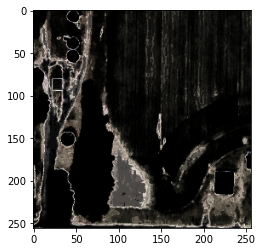

In [52]:
file=with_silos_train.iloc[84]['filename']
filtered=filter2(plt.imread('ai_ready/images/'+file))
plt.imshow(filtered/np.max(filtered))

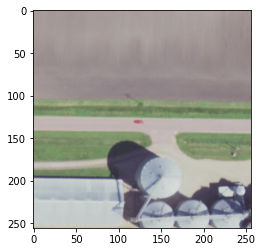

In [35]:
plt.imshow(plt.imread('ai_ready/images/'+file))

In [81]:
f_r(plt.imread('ai_ready/images/'+file)[:,:,0])

TypeError: only size-1 arrays can be converted to Python scalars

Constructing a filter from this average color